In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import itertools as it
import statsmodels.api as sm

# Preparation

## Read datasets

In [2]:
# data of portfolio constituents
crsp_ret = pd.read_csv('data/crsp_data.csv')

# best company ranking
bcwlist = pd.read_excel('data/bcwlist.xlsx',header=2,usecols=np.arange(4))

# factor returns for regression
three_factor = pd.read_csv('data/F-F_Research_Data_Factors.CSV',header=2)[:1165]
mom_factor = pd.read_csv('data/F-F_Momentum_Factor.CSV',header=11)[:1159]

## Clean data

In [3]:
for df in [crsp_ret,bcwlist,three_factor,mom_factor]:
    # Lower case column names
    df.columns = df.columns.map(lambda s: s.strip().lower())

In [4]:
# Data types handling
crsp_ret['permno'] = crsp_ret['permno'].astype(int)
crsp_ret['date'] = pd.to_datetime(crsp_ret['date'],format='%Y%m') + MonthEnd(0)
# CRSP leading dash (bid/ask average) is read as negative price
crsp_ret['prc'] = crsp_ret['prc'].abs()
# Drop records with missing 'permno'
crsp_ret = crsp_ret[crsp_ret['permno']!='nan']

In [5]:
# Drop records with missing 'permno'
bcwlist = bcwlist[bcwlist['permno'].notna()]
# Data types handling
bcwlist['permno'] = bcwlist['permno'].astype(int)
bcwlist['company'] = bcwlist['company'].astype(str)
bcwlist['date'] = pd.to_datetime(bcwlist['year'],format='%Y') + MonthEnd(0)

In [6]:
# Rename column 'date'
mapper = {'unnamed: 0':'date'}
three_factor = three_factor.rename(mapper=mapper,axis=1)
mom_factor = mom_factor.rename(mapper=mapper,axis=1)

# Data types handling
three_factor['date'] = pd.to_datetime(three_factor['date'],format='%Y%m') + MonthEnd(0)
mom_factor['date'] = pd.to_datetime(mom_factor['date'],format='%Y%m') + MonthEnd(0)

# Combine factors df
factor_return = pd.merge(three_factor,mom_factor,how='outer',on='date')

# Set 'date' as index
factor_return.set_index('date',inplace=True)

# Data types handling
factor_return = factor_return.astype(float)

# Percentage point to decimals
factor_return = factor_return/100

# Q1. Portfolio formation

Steps:
1. Group bcwlist by year
    - Create date index for foward filling

2. Group sub-groups by stock

3. Forward fill the rank of that stock until next formation date

4. Add column 'strategy_rule' to crsp_ret

In [7]:
def ffill_stock_rank(group_by_permno,date_index):
    temp = group_by_permno

    # Forward fill the rank
    temp = temp.set_index('date')
    temp = temp.reindex(date_index,method='ffill')

    # Reset index
    temp.index.name = 'date'
    temp = temp.reset_index()
    return temp

def ffill_year_rank(group_by_year):
    temp = group_by_year
    year = temp.name

    # Handle holding date range by year
    if year == 1984:
        # Set date range for reindexing
        start_date,end_date = '1984-04','1993-03'
        date_index = pd.date_range(start_date,end_date,freq='M')

        # Set start date
        temp['date'] = pd.to_datetime(start_date,format='%Y-%m') + MonthEnd(0)
    
    elif year == 1993:
        # Set date range for reindexing
        start_date,end_date = '1993-03','1998-02'
        date_index = pd.date_range(start_date,end_date,freq='M')

        # Set start date
        temp['date'] = pd.to_datetime(start_date,format='%Y-%m') + MonthEnd(0)

    else:
        # Set date range for reindexing
        start_date,end_date = f'{year}-02',f'{year+1}-02'
        date_index = pd.date_range(start_date,end_date,freq='M')
        
        # Set start date
        temp['date'] = pd.to_datetime(start_date,format='%Y-%m') + MonthEnd(0)
    
    # Foward fill by stock
    temp = temp.groupby('permno').apply(ffill_stock_rank,date_index)
    temp = temp.reset_index(drop=True)
    return temp

bcwlist = bcwlist.groupby('year').apply(ffill_year_rank).reset_index(drop=True)
bcwlist.head()

,date,rank,company,permno,year
0,1984-04-30,101,Atlantic Richfield Company,10604,1984
1,1984-05-31,101,Atlantic Richfield Company,10604,1984
2,1984-06-30,101,Atlantic Richfield Company,10604,1984
3,1984-07-31,101,Atlantic Richfield Company,10604,1984
4,1984-08-31,101,Atlantic Richfield Company,10604,1984


In [8]:
crsp = crsp_ret.merge(bcwlist[['date','rank','permno']],on=['date','permno'],how='left')
crsp['strategy_rule'] = np.where(crsp['rank'].notna(),1,0)
crsp[crsp['strategy_rule']!=0].head()

,permno,date,ret,prc,shrout,rank,strategy_rule
144,10078,1998-02-28,-0.006519,47.62500,377367.0,69.0,1
145,10078,1998-03-31,-0.124016,41.71875,378811.0,69.0,1
146,10078,1998-04-30,-0.012734,41.18750,378811.0,69.0,1
147,10078,1998-05-31,-0.027314,40.06250,378811.0,69.0,1
148,10078,1998-06-30,0.084243,43.43750,381262.0,69.0,1


# Q2 Portfolio Weights

## (a) $eq\_weight_{i,t} = \frac{1}{n_t}$

In [9]:
def get_eq_weights(group_by_date):
    temp = group_by_date
    num_stocks = temp['strategy_rule'].sum()
    # w = 1/n OR 0/n = 0
    temp['eq_weight'] = temp['strategy_rule']/num_stocks
    temp = temp.reset_index(drop=True)
    return temp

# w_t = 1/n_t
crsp = crsp.groupby('date').apply(get_eq_weights).reset_index(drop=True)
crsp[crsp['eq_weight'].notna()].head()

,permno,date,ret,prc,shrout,rank,strategy_rule,eq_weight
420,10145,1984-04-30,0.036408,53.375,53459.0,NaN,0,0.000000
421,10604,1984-04-30,0.059299,49.125,249753.0,101.0,1,0.013514
422,11607,1984-04-30,-0.067961,24.000,56484.0,101.0,1,0.013514
423,11703,1984-04-30,0.025381,50.500,238868.0,101.0,1,0.013514
424,11754,1984-04-30,-0.047151,60.625,165700.0,101.0,1,0.013514


## (b) $market\_value_{i,t} = prc_{i,t} \times shrout_{i,t}$

In [10]:
crsp['market_value'] = crsp['prc'] * crsp['shrout']
crsp[crsp['market_value'].notna()].head()

,permno,date,ret,prc,shrout,rank,strategy_rule,eq_weight,market_value
0,10145,1984-01-31,-0.056054,52.625,53459.0,NaN,0,NaN,2.813280e+06
1,10604,1984-01-31,0.063584,45.250,249753.0,NaN,0,NaN,1.130132e+07
2,11607,1984-01-31,0.026786,28.750,56483.0,NaN,0,NaN,1.623886e+06
3,11703,1984-01-31,-0.043269,49.750,238868.0,NaN,0,NaN,1.188368e+07
4,11754,1984-01-31,-0.042693,72.875,165700.0,NaN,0,NaN,1.207539e+07


## (c) $val\_weight_{i,t} = \frac{market\_value_{i,t-1}}{\sum market\_value_{i,t-1} }$

In [11]:
# Offset 'market_value' to next month
def offset_market_value(group_by_permno):
    temp = group_by_permno

    # Sort by oldest to newest date
    temp = temp.sort_values('date')

    # Offset to next month
    temp['offset_market_value'] = temp['market_value'].shift(1)
    temp = temp.reset_index(drop=True)
    return temp
crsp = crsp.groupby('permno').apply(offset_market_value).reset_index(drop=True)
crsp.head()

,permno,date,ret,prc,shrout,rank,strategy_rule,eq_weight,market_value,offset_market_value
0,10078,1986-02-28,NaN,NaN,NaN,NaN,0,0.0,NaN,NaN
1,10078,1986-03-31,NaN,14.5625,27108.0,NaN,0,0.0,394760.250,NaN
2,10078,1986-04-30,0.111588,16.1875,27108.0,NaN,0,0.0,438810.750,394760.25
3,10078,1986-05-31,0.111969,18.0000,27108.0,NaN,0,0.0,487944.000,438810.75
4,10078,1986-06-30,-0.118056,15.8750,27179.0,NaN,0,0.0,431466.625,487944.00


In [12]:
def get_val_weights(group_by_date):
    temp = group_by_date
    tot_market_value = temp[temp['strategy_rule']==1]['offset_market_value'].sum()
    # w = mv / totalmv OR 0
    temp['val_weight'] = np.where(temp['strategy_rule']==1,
                                  temp['offset_market_value']/tot_market_value,
                                  0)
    temp = temp.reset_index(drop=True)
    return temp
# w_t = mv_t / totalmv_t
crsp = crsp.groupby('date').apply(get_val_weights).reset_index(drop=True)
crsp[crsp['val_weight']!=0].head()

,permno,date,ret,prc,shrout,rank,strategy_rule,eq_weight,market_value,offset_market_value,val_weight
421,10604,1984-04-30,0.059299,49.125,249753.0,101.0,1,0.013514,1.226912e+07,1.158230e+07,0.040025
422,11607,1984-04-30,-0.067961,24.000,56484.0,101.0,1,0.013514,1.355616e+06,1.454463e+06,0.005026
423,11703,1984-04-30,0.025381,50.500,238868.0,101.0,1,0.013514,1.206283e+07,1.176425e+07,0.040654
424,11754,1984-04-30,-0.047151,60.625,165700.0,101.0,1,0.013514,1.004556e+07,1.054266e+07,0.036432
425,11850,1984-04-30,0.103560,42.625,846097.0,101.0,1,0.013514,3.606488e+07,3.268050e+07,0.112935


# Q3 Portfolio Return

## (a) eq_return, val_return

$eq\_return_t = \sum eq\_weight_{i,t} \times ret_{i,t}$

In [13]:
def get_eq_return(group_by_date):
    temp = group_by_date
    ret_t = (temp['ret'] * temp['eq_weight']).sum()
    return ret_t
eq_return = crsp.groupby('date').apply(get_eq_return)

$val\_return_t = \sum val\_weight_{i,t} \times ret_{i,t}$

In [14]:
def get_val_return(group_by_date):
    temp = group_by_date
    ret_t = (temp['ret'] * temp['val_weight']).sum()
    return ret_t
val_return = crsp.groupby('date').apply(get_val_return)

In [15]:
portfolios_return = pd.DataFrame({'eq_return': eq_return,
                                  'val_return': val_return})
portfolios_return = portfolios_return.loc['1984-04':'2009-12']
portfolios_return.head()

,eq_return,val_return
date,,
1984-04-30,0.000588,0.021919
1984-05-31,-0.059693,-0.046489
1984-06-30,0.050376,0.013179
1984-07-31,-0.043694,-0.006774
1984-08-31,0.128806,0.116991


## (b) $cum\_return_T = \prod^{T}_{t=0} (1+return_t)$

In [16]:
cum_return = (1+portfolios_return).cumprod()
cum_return.columns = ['cum_eq_return','cum_val_return']
cum_return.head()

,cum_eq_return,cum_val_return
date,,
1984-04-30,1.000588,1.021919
1984-05-31,0.940860,0.974411
1984-06-30,0.988257,0.987253
1984-07-31,0.945075,0.980565
1984-08-31,1.066806,1.095283


# Q4 Backtesting

## (a) Plot

### Code

Text(1, 0, '1282%')

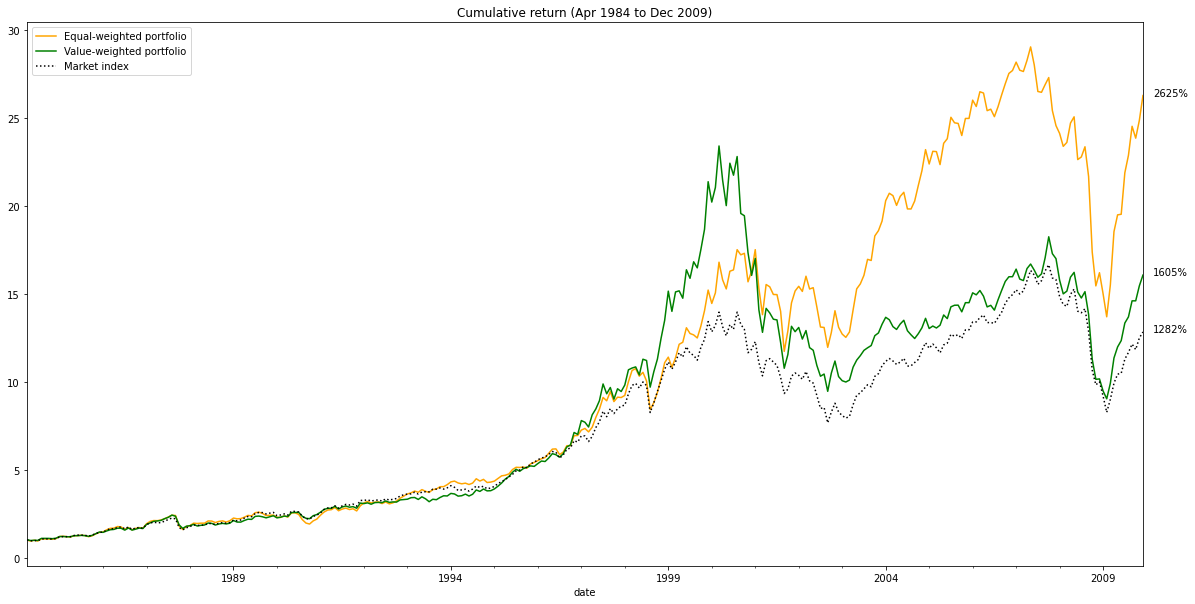

In [17]:
mkt_return = (factor_return['mkt-rf'] + factor_return['rf'])
cum_return['cum_mkt_return'] = (1+mkt_return).loc['1984-04':'2009-12'].cumprod()

ax = cum_return.plot(figsize = (20,10),
                     title = 'Cumulative return (Apr 1984 to Dec 2009)',
                     style = ['-','-',':'],
                     color = ['orange','green','black'])

ax.legend(['Equal-weighted portfolio','Value-weighted portfolio','Market index'])

ax.annotate(f"{int(cum_return['cum_eq_return'][-1]*100):d}%",
            xy = (cum_return.index[-1],cum_return['cum_eq_return'][-1]),
            xytext = (1,0),
            textcoords = 'offset fontsize',
            )

ax.annotate(f"{int(cum_return['cum_val_return'][-1]*100):d}%",
            xy = (cum_return.index[-1],cum_return['cum_val_return'][-1]),
            xytext = (1,0),
            textcoords = 'offset fontsize')

ax.annotate(f"{int(cum_return['cum_mkt_return'][-1]*100):d}%",
            xy = (cum_return.index[-1],cum_return['cum_mkt_return'][-1]),
            xytext = (1,0),
            textcoords = 'offset fontsize')

## (b) Performance metrics $E(r), SR, \alpha_{CAPM}, \beta_{CAPM}, \alpha_{Carhart}, \beta_{Carhart}$

### Average monthly return, Sharpe Ratio

In [18]:
df = pd.DataFrame()
p = pd.DataFrame()

In [19]:
df['Average monthly return (%)'] = portfolios_return.mean() * 100
df['Monthly Sharpe Ratio'] = portfolios_return.mean() / portfolios_return.std()
df

,Average monthly return (%),Monthly Sharpe Ratio
eq_return,1.214374,0.222616
val_return,1.048694,0.194755


### CAPM


In [20]:
reg_data = portfolios_return.merge(factor_return,on='date',how='left')
# Calculate excess return
reg_data['eq_return-rf'] = reg_data['eq_return'] - reg_data['rf']
reg_data['val_return-rf'] = reg_data['val_return'] - reg_data['rf']

reg_data.drop(['eq_return','val_return'],axis=1,inplace=True)

In [21]:
y = reg_data['eq_return-rf']
X = sm.add_constant(reg_data['mkt-rf'])

model = sm.OLS(y,X)
result = model.fit()

alphas = [result.params[0] * 100]
p_alphas = [result.pvalues[0]]

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           eq_return-rf   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     2685.
Date:                Sat, 14 Oct 2023   Prob (F-statistic):          7.85e-154
Time:                        21:21:26   Log-Likelihood:                 812.19
No. Observations:                 309   AIC:                            -1620.
Df Residuals:                     307   BIC:                            -1613.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.035      0.043     6.8e-05       0.004
mkt-rf         1.1308      0.022     51.818      0.000       1.088       1.174
==============================================================================
Omnibus:                       36.092   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.946
Skew:                           0.662   Prob(JB):                     4.79e-15
Kurtosis:                       4.836   Cond. No.                         21.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
y = reg_data['val_return-rf']
X = sm.add_constant(reg_data['mkt-rf'])

model = sm.OLS(y,X)
result = model.fit()

alphas.append(result.params[0] * 100)
p_alphas.append(result.pvalues[0])

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          val_return-rf   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     1500.
Date:                Sat, 14 Oct 2023   Prob (F-statistic):          3.52e-120
Time:                        21:21:26   Log-Likelihood:                 738.96
No. Observations:                 309   AIC:                            -1474.
Df Residuals:                     307   BIC:                            -1466.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.568      0.570      -0.002       0.003
mkt-rf         1.0710      0.028     38.724      0.000       1.017       1.125
==============================================================================
Omnibus:                       21.526   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.977
Skew:                           0.078   Prob(JB):                     2.35e-16
Kurtosis:                       5.359   Cond. No.                         21.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
df['CAPM alpha (%)'] = pd.Series(alphas,index=['eq_return','val_return'])
p['CAPM alpha (%)'] = pd.Series(p_alphas,index=['eq_return','val_return'])

### Carhart

In [24]:
y = reg_data['eq_return-rf']
X = sm.add_constant(reg_data[['mkt-rf','hml','smb','mom']])

model = sm.OLS(y,X)
result = model.fit()

alphas = [result.params[0] * 100]
betas_mkt = [result.params[1]]
betas_hml = [result.params[2]]
betas_smb = [result.params[3]]
betas_mom = [result.params[4]]

p_alphas = [result.pvalues[0]]
p_betas_mkt = [result.pvalues[1]]
p_betas_hml = [result.pvalues[2]]
p_betas_smb = [result.pvalues[3]]
p_betas_mom = [result.pvalues[4]]

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           eq_return-rf   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     949.0
Date:                Sat, 14 Oct 2023   Prob (F-statistic):          2.55e-170
Time:                        21:21:26   Log-Likelihood:                 862.37
No. Observations:                 309   AIC:                            -1715.
Df Residuals:                     304   BIC:                            -1696.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.465      0.001       0.001       0.005
mkt-rf         1.0829      0.020     53.368      0.000       1.043       1.123
hml            0.0514      0.031      1.643      0.101      -0.010       0.113
smb            0.1905      0.028      6.860      0.000       0.136       0.245
mom           -0.1504      0.018     -8.253      0.000      -0.186      -0.115
==============================================================================
Omnibus:                       20.944   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.830
Skew:                           0.486   Prob(JB):                     3.33e-07
Kurtosis:                       4.172   Cond. No.                         40.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
y = reg_data['val_return-rf']
X = sm.add_constant(reg_data[['mkt-rf','hml','smb','mom']])

model = sm.OLS(y,X)
result = model.fit()

alphas.append(result.params[0] * 100)
betas_mkt.append(result.params[1])
betas_hml.append(result.params[2])
betas_smb.append(result.params[3])
betas_mom.append(result.params[4])

p_alphas.append(result.pvalues[0])
p_betas_mkt.append(result.pvalues[1])
p_betas_hml.append(result.pvalues[2])
p_betas_smb.append(result.pvalues[3])
p_betas_mom.append(result.pvalues[4])

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          val_return-rf   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     476.7
Date:                Sat, 14 Oct 2023   Prob (F-statistic):          1.40e-129
Time:                        21:21:26   Log-Likelihood:                 771.67
No. Observations:                 309   AIC:                            -1533.
Df Residuals:                     304   BIC:                            -1515.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.189      0.029       0.000       0.005
mkt-rf         1.0099      0.027     37.112      0.000       0.956       1.063
hml           -0.3453      0.042     -8.229      0.000      -0.428      -0.263
smb           -0.1515      0.037     -4.069      0.000      -0.225      -0.078
mom           -0.0645      0.024     -2.641      0.009      -0.113      -0.016
==============================================================================
Omnibus:                       18.059   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.046
Skew:                           0.370   Prob(JB):                     2.99e-07
Kurtosis:                       4.337   Cond. No.                         40.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
df['Carhart alpha (%)'] = pd.Series(alphas,index=['eq_return','val_return'])
df['Market beta'] = pd.Series(betas_mkt,index=['eq_return','val_return'])
df['HML beta'] = pd.Series(betas_hml,index=['eq_return','val_return'])
df['SMB beta'] = pd.Series(betas_smb,index=['eq_return','val_return'])
df['MOM beta'] = pd.Series(betas_mom,index=['eq_return','val_return'])

p['Carhart alpha (%)'] = pd.Series(p_alphas,index=['eq_return','val_return'])
p['Market beta'] = pd.Series(p_betas_mkt,index=['eq_return','val_return'])
p['HML beta'] = pd.Series(p_betas_hml,index=['eq_return','val_return'])
p['SMB beta'] = pd.Series(p_betas_smb,index=['eq_return','val_return'])
p['MOM beta'] = pd.Series(p_betas_mom,index=['eq_return','val_return'])

In [27]:
def add_star(x):
    try:
        x = x+'*'
    except:
        pass
    return x

df = df.applymap(lambda x: str(round(x,2)))
df[p<0.10] = df[p<0.10].applymap(add_star)
df[p<0.05] = df[p<0.05].applymap(add_star)
df[p<0.01] = df[p<0.01].applymap(add_star)

df.index = ['Equal-weighted','Value-weighted']

### Summary table

In [28]:
print('*   : significant at 10%')
print('**  : significant at 5%')
print('*** : significant at 1%')
df.T

*   : significant at 10%
**  : significant at 5%
*** : significant at 1%


,Equal-weighted,Value-weighted
Average monthly return (%),1.21,1.05
Monthly Sharpe Ratio,0.22,0.19
CAPM alpha (%),0.2**,0.07
Carhart alpha (%),0.31***,0.26**
Market beta,1.08***,1.01***
HML beta,0.05,-0.35***
SMB beta,0.19***,-0.15***
MOM beta,-0.15***,-0.06***


## (c) $Volatility, Downside Risk, Value At Risk, Expected Shortfall$

In [29]:
df = pd.DataFrame()

### Volatility, Downside risk

In [30]:
df['Volatility (%)'] = portfolios_return.std() * 100

def get_downside_risk(series,threshold=0):
    downside = np.where(series<threshold,threshold-series,0)**2
    return np.sqrt(downside.sum())/len(series)

df['Downside risk (%)'] = portfolios_return.apply(get_downside_risk) * 100

### Value-at-risk, Expected shortfall

In [31]:
# 5% quantile
df['Value-at-risk 95 (%)'] = portfolios_return.quantile(q=0.05) * 100
# 1% quantile
df['Value-at-risk 99 (%)'] = portfolios_return.quantile(q=0.01) * 100

df['Expected shortfall 95 (%)'] = portfolios_return[portfolios_return < portfolios_return.quantile(q=0.05)].mean()
df['Expected shortfall 99 (%)'] = portfolios_return[portfolios_return < portfolios_return.quantile(q=0.01)].mean()

In [32]:
df = df.applymap(lambda x: str(round(x,2)))
df.index = ['Equal-weighted','Value-weighted']

### Summary table

In [33]:
df.T

,Equal-weighted,Value-weighted
Volatility (%),5.46,5.38
Downside risk (%),0.2,0.2
Value-at-risk 95 (%),-7.82,-7.78
Value-at-risk 99 (%),-15.88,-14.14
Expected shortfall 95 (%),-0.12,-0.12
Expected shortfall 99 (%),-0.19,-0.18
